This notebook is just a showcase of how we did the sampling. The CLI command `python -m mastodon_search choose-instances` does the same, but additionally probes the timelines API of all sampled instances, removes the ones that require a token or don't answer after a timeout. Because this takes a good amount of time, it is not part of this notebook.

In [1]:
from pathlib import Path
from scipy.stats import lognorm
from numpy import exp

from mastodon_search.instance_data.analyze import Analyzer

In [2]:
INSTANCE_DATA_PATH = Path('/mnt/ceph/storage/data-in-progress/data-teaching/theses/wstud-thesis-ernst/instance-data/mastodon.jsonl')
SAMPLE_OUTPUT_FILE_NAME = 'sampled_instances'
SAMPLE_OUTPUT_FILE_EXT = 'txt'
COLUMNS = ['total_users', 'monthly_users', 'total_statuses',
        'mean_weekly_statuses', 'mean_weekly_logins', 'mean_weekly_registrations']
NUM_SAMPLES = 1000

In [3]:
cols_prob_measures = {
    col: lognorm
    for col in COLUMNS
}
with open(INSTANCE_DATA_PATH, 'r') as file:
    an = Analyzer(file)

Number of instances in input file: 22178
Removed for (partially) no data: 11822
↳ Almost all of these instances run Fediverse software other than Mastodon, some run Mastodon with a non-public API.
Removed duplicates: 2
Remaining: 10354


In [4]:
df = an.df
df

,total_users,monthly_users,total_statuses,mean_weekly_statuses,mean_weekly_logins,mean_weekly_registrations
instance,,,,,,
0371.uk,1,1,125,3.50,1.00,0.0
0ab.uk,2,2,14,0.00,0.50,0.0
0rb.it,7,2,626,0.00,1.50,0.0
0v0.ch,1,1,46,0.50,1.00,0.0
0x3c.pl,91,9,2305,1.00,5.00,0.0
...,...,...,...,...,...,...
zusammenhalt.de,1,1,32,5.75,1.00,0.0
zusammenkunft.net,2,2,5164,69.00,2.00,0.0
zweibruecken.social,3,2,497,0.75,1.25,0.0


array([[<Axes: title={'center': 'total_users'}>,
        <Axes: title={'center': 'monthly_users'}>],
       [<Axes: title={'center': 'total_statuses'}>,
        <Axes: title={'center': 'mean_weekly_statuses'}>],
       [<Axes: title={'center': 'mean_weekly_logins'}>,
        <Axes: title={'center': 'mean_weekly_registrations'}>]],
      dtype=object)

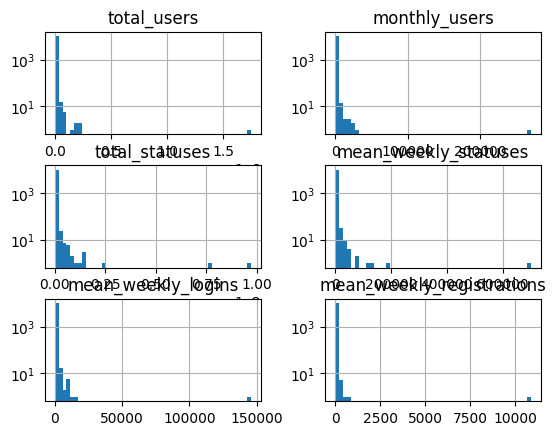

In [5]:
df[cols_prob_measures.keys()].hist(log=True, bins=50)

In [6]:
# Estimate probability distributions over activity columns
distributions = {
    col: dist.fit(df[col])
    for col, dist in cols_prob_measures.items()
}
distributions

/home/tschaeggaer/Projekte/thesis-ernst/code/venv/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6120: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/home/tschaeggaer/Projekte/thesis-ernst/code/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/tschaeggaer/Projekte/thesis-ernst/code/venv/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6111: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


{'total_users': (2.0729048820355116, -0.004680968532170727, 6.242806349500355),
 'monthly_users': (221.72123191495947, -5e-324, 5.902632613732202e-32),
 'total_statuses': (1.4411050964763603,
  -1344.8609145250343,
  3249.8875301354738),
 'mean_weekly_statuses': (351.06299082310255, -5e-324, 2.25951465092792e-106),
 'mean_weekly_logins': (228.75703300629735, -5e-324, 2.0789701713187276e-34),
 'mean_weekly_registrations': (257.5141576485152,
  -5e-324,
  4.22291809218239e-279)}

In [7]:
# Compute normalize activity score by dividing by the estimated probability.
for col, dist in cols_prob_measures.items():
    shape, location, scale = distributions[col]
    df[f"{col}_log_probability"] = dist.logpdf(df[col], shape, location, scale)

# Compute joint probability (under assumption of independence; using log probabilities for numerical stability)
df["log_probability"] = 0
for col in cols_prob_measures.keys():
    df["log_probability"] += df[f"{col}_log_probability"]

df.sort_values("log_probability", inplace=True)
df

,total_users,monthly_users,total_statuses,mean_weekly_statuses,mean_weekly_logins,mean_weekly_registrations,total_users_log_probability,monthly_users_log_probability,total_statuses_log_probability,mean_weekly_statuses_log_probability,mean_weekly_logins_log_probability,mean_weekly_registrations_log_probability,log_probability
instance,,,,,,,,,,,,,
mastodon.social,1745090,269790,77415689,701763.00,145442.25,10864.75,-34.320908,-18.898231,-43.903457,-20.508630,-18.315573,-18.951602,-154.898402
mstdn.social,219773,24577,14414925,122489.00,14818.75,449.25,-26.701320,-16.498342,-34.745880,-18.759432,-16.027833,-15.734740,-128.467548
mastodon.online,194721,24056,7374520,83010.50,12854.50,723.25,-26.287129,-16.476880,-31.474125,-18.369573,-15.885397,-16.215564,-124.708669
mas.to,168048,18481,6683778,74736.50,11371.75,219.50,-25.787564,-16.212800,-31.012261,-18.264358,-15.762632,-15.011528,-122.051143
mastodon.world,180994,20214,4601165,49064.75,10729.75,387.25,-26.038598,-16.302581,-29.301279,-17.842662,-15.704424,-15.584782,-120.774326
...,...,...,...,...,...,...,...,...,...,...,...,...,...
userlist.social,1,0,0,0.00,0.00,0.00,-2.040866,733.519453,-8.675825,736.641132,733.839130,737.889352,2931.172377
mastodon.nube61.syncloud.it,1,0,0,0.00,0.00,0.00,-2.040866,733.519453,-8.675825,736.641132,733.839130,737.889352,2931.172377
urbansound.social,1,0,0,0.00,0.00,0.00,-2.040866,733.519453,-8.675825,736.641132,733.839130,737.889352,2931.172377


In [8]:
df["weight"] = exp(-df["log_probability"])
df_sample = df.sample(n=NUM_SAMPLES, replace=False, weights=df["weight"])
df_sample

,total_users,monthly_users,total_statuses,mean_weekly_statuses,mean_weekly_logins,mean_weekly_registrations,total_users_log_probability,monthly_users_log_probability,total_statuses_log_probability,mean_weekly_statuses_log_probability,mean_weekly_logins_log_probability,mean_weekly_registrations_log_probability,log_probability,weight
instance,,,,,,,,,,,,,,
mastodon.social,1745090,269790,77415689,701763.00,145442.25,10864.75,-34.320908,-18.898231,-43.903457,-20.508630,-18.315573,-18.951602,-154.898402,1.868620e+67
mstdn.social,219773,24577,14414925,122489.00,14818.75,449.25,-26.701320,-16.498342,-34.745880,-18.759432,-16.027833,-15.734740,-128.467548,6.205076e+55
mastodon.online,194721,24056,7374520,83010.50,12854.50,723.25,-26.287129,-16.476880,-31.474125,-18.369573,-15.885397,-16.215564,-124.708669,1.446394e+54
mas.to,168048,18481,6683778,74736.50,11371.75,219.50,-25.787564,-16.212800,-31.012261,-18.264358,-15.762632,-15.011528,-122.051143,1.014233e+53
fedibird.com,38475,12756,13716516,132120.25,10238.25,102.00,-21.066495,-15.841443,-34.496020,-18.835279,-15.657456,-14.237683,-120.134376,1.491753e+52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
milliways.social,31,13,4201,67.75,9.00,0.50,-5.380924,-8.941717,-9.973920,-11.244192,-8.609598,-8.868001,-53.018351,1.060663e+23
mast.shitpostbot.com,18,6,12841,289.50,2.75,0.25,-4.669069,-8.167362,-11.367171,-12.699447,-7.422180,-8.168164,-52.493394,6.274675e+22
snailedit.social,55,25,2205,26.00,22.50,0.25,-6.206273,-9.596639,-9.460889,-10.284544,-9.527293,-8.168164,-53.243803,1.328892e+23


array([[<Axes: title={'center': 'total_users'}>,
        <Axes: title={'center': 'monthly_users'}>],
       [<Axes: title={'center': 'total_statuses'}>,
        <Axes: title={'center': 'mean_weekly_statuses'}>],
       [<Axes: title={'center': 'mean_weekly_logins'}>,
        <Axes: title={'center': 'mean_weekly_registrations'}>]],
      dtype=object)

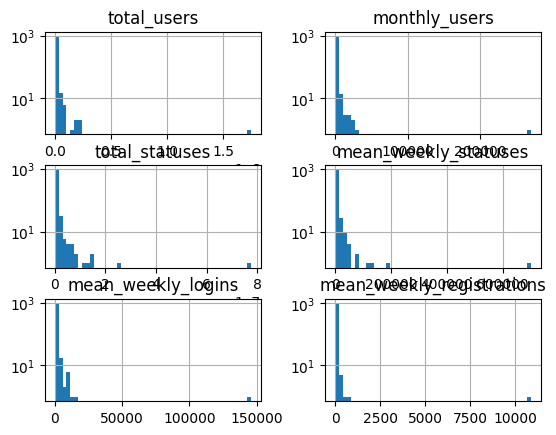

In [9]:
df_sample[cols_prob_measures.keys()].hist(log=True, bins=50)

In [10]:
df_sample.sort_index(inplace=True)
# Full DataFrame. Maybe we want to have that data later.
df_sample.to_csv(Path(SAMPLE_OUTPUT_FILE_NAME + '_full_data.' + SAMPLE_OUTPUT_FILE_EXT))
sampled_instances = df_sample.reset_index()['instance']
# Raw instance list only.
sampled_instances.to_csv(Path(SAMPLE_OUTPUT_FILE_NAME + '.' + SAMPLE_OUTPUT_FILE_EXT), index=False, header=False)
sampled_instances

0      23.illuminati.org
1          3615.computer
2               3dp.chat
3                 3zi.ru
4              4bear.com
             ...        
995            zeroes.ca
996            zhub.link
997              zirk.us
998       zpravobot.news
999          zug.network
Name: instance, Length: 1000, dtype: object